In [1]:
import numpy as np
import scipy as scp
from random import seed
from random import random
from random import randrange
from random import uniform
from matplotlib import pyplot as plt
import copy
from time import time
from sklearn import preprocessing

In [7]:
class NeuralNetwork:
    class BaseNode:
        def __init__(self, outer, function):
            self.outer = outer
            self.function = function
    class StartNode(BaseNode):
        def __init__(self, outer, function):
            super().__init__(outer, function)
            self.values = []
            self.weightIndexes = []
        def setWeightIndexes(self, weightIndexes):
            self.biasIndex = weightIndexes.pop()
            self.weightIndexes = weightIndexes
        def setVal(self, val):
            self.calculated = False
            self.values = val
        def getResult(self):
            if self.calculated:
                return self.sum
            if not self.values.any():
                raise Exception('No values')
            else:
                sum = self.outer.genes[self.biasIndex]
                for i in range(len(self.values)):
                    sum = self.outer.genes[self.weightIndexes[i]]*self.values[i]
            self.sum = self.function(sum)
            self.calculated = True
            return self.sum
        def reset(self, isFirst):
            self.calculated = False
    class Node(BaseNode):
        def __init__(self, outer, function):
            super().__init__(outer, function)
            self.prevNodes = []
            self.weightIndexes = []
        def addPrevNode(self, node):
            self.prevNodes.append(node)
        def addPrevNodes(self, nodes, weightIndexes):
            for n in nodes:
                self.addPrevNode(n)
            self.biasIndex = weightIndexes.pop()
            self.weightIndexes = weightIndexes
        def getResult(self):
            if self.calculated:
                return self.sum
            if not self.prevNodes:
                raise Exception('No previous nodes')
            else:
                sum = self.outer.genes[self.biasIndex]
                for i in range(len(self.prevNodes)):
                    sum += self.outer.genes[self.weightIndexes[i]]*self.prevNodes[i].getResult()
            self.sum = self.function(sum)
            self.calculated = True
            return self.sum
        def reset(self, isFirst):
            self.calculated = False
            if isFirst:
                for n in self.prevNodes:
                    n.reset(n == self.prevNodes[-1])
    def __init__(self, input_data, output_data, shape, function):
        self.calculated = False
        self.input_data = input_data
        self.output_data = output_data
        self.noOfValues = len(input_data)
        tmpshape = shape.copy()
        self.shape = shape
        self.genes = []
        self.startNodes = []
        if not tmpshape:
            for i in range(self.noOfValues + 1):
                self.genes.append(uniform(-1,1))
            self.startNodes.append(self.StartNode(self, function))
            self.endNode = self.startNodes[0]
            self.endNode.setWeightIndexes(list(range(self.noOfValues + 1)))
        else:
            for i in range(tmpshape[0]):
                self.startNodes.append(self.StartNode(self, function))
                weightIndexes = list(range(self.noOfValues + 1))
                length = len(self.genes)-1
                for j in range(self.noOfValues + 1):
                    weightIndexes[j] += length
                    self.genes.append(uniform(-1,1))
                self.startNodes[i].setWeightIndexes(weightIndexes)
            tmpshape.remove(tmpshape[0])
            prev = self.startNodes
            lastIndex = len(self.genes)-1
            for n in shape:
                if n < 1:
                    raise Exception('No layer can have less than one node')
                tmp = []
                for i in range(n):
                    tmp.append(self.Node(self, function))
                    weightIndexes = list(range(len(prev) + 1))
                    length = len(self.genes)-1
                    for j in range(len(prev) + 1):
                        weightIndexes[j] += length
                        self.genes.append(uniform(-1,1))
                    tmp[i].addPrevNodes(prev, weightIndexes)
                prev = tmp
            self.endNode = self.Node(self, function)
            weightIndexes = list(range(len(prev) + 1))
            length = len(self.genes)-1
            for j in range(len(prev)):
                weightIndexes[j] += length
                self.genes.append(uniform(-1,1))
            self.endNode.addPrevNodes(prev, weightIndexes)
    def getResult(self):
        return self.endNode.getResult()
    def iterate(self):
        correctlyPredicted = 0
        for i in range(len(self.input_data)):
            self.setVal(self.input_data[i])
            if (self.getResult() < 0.5 and self.output_data[i] == 0) or (self.getResult() >= 0.5 and self.output_data[i] == 1):
                correctlyPredicted += 1
        self.calculated = True
        return correctlyPredicted/len(self.input_data)*100
    def calcFitness(self):
        if not self.calculated:
            self.fitness = self.iterate()
    def setVal(self, values):
        self.calculated = False
        self.endNode.reset(True)
        for n in self.startNodes:
            n.setVal(values)
    def reset(self):
        self.endNode.reset(True)
    def mutate(self, probability):
        for i in range(len(self.genes)):
            if random() < probability:
                if self.genes[i] < 1 and self.genes[i] > -1:
                    self.genes[i] += uniform(-1, 1)
                else:
                    self.genes[i] *= uniform(-1, 2)
    
def breed(network1, network2, mutProb):
    network = copy.deepcopy(network1)
    if network.shape != network2.shape or network.noOfValues != network2.noOfValues:
        raise Exception('Networks have different shapes or functions!')
    for i in range(len(network1.genes)):
        network.genes[i] += network2.genes[i]
        network.genes[i] /= 2
    network.mutate(mutProb)
    network.calculated = False
    network.reset()
    return network
    
def GeneticAlgorithm(input_data, output_data, solutions_num, input_layers_num, hidden_layers_num, 
                     activation_func, generation_num, mutation_perc, save_best):
    population = []
    global best
    maxRes = 0
    x = range(generation_num)
    y = []
    shape = []
    shape.append(input_layers_num)
    shape = shape + hidden_layers_num
    for i in range(solutions_num):
        nn = NeuralNetwork(input_data, output_data, shape, activation_func)
        population.append(nn)
        if i == 0:
            best = population[i]
    for i in range(generation_num):
        print(i)
        maxFitness = 0
        minFit = 100
        fitness = []
        for j in range(solutions_num):
            population[j].calcFitness()
            fitness.append(population[j].fitness)
            if population[j].fitness > maxFitness:
                maxFitness = population[j].fitness
            if population[j].fitness < minFit:
                minFit = population[j].fitness
            if population[j].fitness > maxRes:
                maxRes = population[j].fitness
                best = population[j]
        if minFit == maxRes:
            minFit = 0
        for j in range(solutions_num):
            fitness[j] = (fitness[j] - minFit)**2
            if j != 0:
                fitness[j] += fitness[j-1]
        y.append(maxFitness)
        newPopulation = []
        for j in range(solutions_num):
            if save_best and j == 0:
                newPopulation.append(best)
                continue
            parents = []
            for k in range(2):
                rdm = uniform(0, fitness[-1])
                for m in range(len(fitness)):
                    if rdm > fitness[m]:
                        parents.append(population[m])
                        break
                    else:
                        parents.append(population[-1])
            nn = breed(parents[0], parents[1], mutation_perc/100)
            newPopulation.append(nn)
        population = newPopulation
    plt.plot(x, y)
    print("maxFitness = " + str(maxRes))

In [4]:
data = np.genfromtxt('diabetes.csv', delimiter=',')
min_max_scaler = preprocessing.MinMaxScaler()
cols = min_max_scaler.fit_transform(data[:,:8].T).T   # pierwsze 8 kolumn
print(cols[3])
last_col = data[:,8]

[0.00887747 0.94671384 0.70159752 0.24333657 1.         0.29768845
 0.         0.2220221 ]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
maxFitness = 65.10416666666666


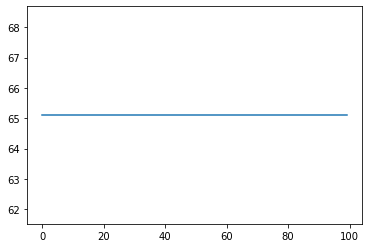

In [8]:
GeneticAlgorithm(cols, last_col, 10, 5, [2], lambda x: x, 100, 1, True)

In [102]:
class a:
    def __init__(self, v):
        self.list = v
    def write(self):
        print(self.list)

c = [1, 2]
myList = a(c)
myList2 = a(myList.list)
myList.write()
c[0] = 4
myList.write()
myList2.write()
c[1] = 5
myList.write()
myList2.write()

[1, 2]
[4, 2]
[4, 2]
[4, 5]
[4, 5]


In [95]:
a = []
for i in range(2):
    a.append(i)
a

[0, 1]